# Лабораторная работа №4 по курсу "Распознавание образов"

# Линейный дискриминантный анализ (LDA)

Применение LDA "вручную" и "из коробки". Произвести снижение размерности данных в датасете load_breast_cancer() с использованием LDA, получить проекционную плоскость, построить гистограммы распредления данных после проекции, определить порог классификации.Произвести классификацию с LDA, построить матрицу неточности на train и test наборах.

Cравнить полученные вектора W, средние значения, результаты проекции, сделать выводы.

Предварительно создать train и test наборы создать с помощью train_test_split, random_state = 42, чтобы у всех получились одинаковые результаты. Оцените количество объектов в каждом классе.


"Вручную":

1. Рассчитать среднее векторов признаков для классов
2. Расчитать матрицы внутриклассовых разбросов и общую матрицу внутриклассового разброса. (еще нормировать на общее число примеров в train наборе)
2. Расчитать проекционный вектор
4. Получить проекцию данных
5. Построить гистограммы распредления новых признаков
6. Найти порог класификации
7. Оценить точность классификации на test наборе: построить матрицу неточности.

"Из коробки":
1. Применить LinearDiscriminantAnalysis() с разными solver (solver{‘svd’, ‘lsqr’, ‘eigen’}) к train набору
2. Сравнить средние значения классов с значеними из предыдущего метода
3. Сравнить вектор W проекции с вектором из предыдущего метода
4. Выполнить transform и получить проекцию данных
5. Сравнить полученные распределения проекций данных классов с распредлением из предыдущего метода, сравнить реузльтат для разных solver
6. Оценить точность классификации на test наборе: построить матрицу неточности.

В итоге лучше всего написать функцию которая построит subplots распредлений данных в виде гистограммы для всех перечисленных методов и функцию для оценки точности классификации.

Сделать выводы. Ответить на вопросы:
1. Какая размернить данных получилась в итоге применения метода снижения размерности LDA?
2. Как определить какое количество признаков получится в итоге примнения метода снижения размерности признаков с LDA? А с PCA?
3. Чем отлтичаются LDA и PCA?
4. Что такое матрица неточности (confusion matrix)?
5. Зачем делить выборку на train и test? Почему мы не создали еще и val набор?
6. Зачем фиксировать random_state?
7. Есть ли в данной задаче дисбалланс классов?
8. Что такое задача классификации и сколько классов в данном датасете?

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
from math import sqrt, exp, pi
from scipy.stats import norm
from matplotlib.colors import ListedColormap

from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats

data = datasets.load_breast_cancer()

In [2]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
np.mean(data['data'][data['target']==0])

94.2725320292453

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=0.33, random_state=42)

In [5]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(381, 30) (188, 30) (381,) (188,)


In [6]:
X_train_0 = X_train[y_train==0]
y_train_0 = y_train[y_train==0]
X_train_1 = X_train[y_train==1]
y_train_1 = y_train[y_train==1]
X_test_0 = X_test[y_test==0]
y_test_0 = y_test[y_test==0]
X_test_1 = X_test[y_test==1]
y_test_1 = y_test[y_test==1]

## "Вручную":

### 1. Рассчитать среднее векторов признаков для классов

In [7]:
mean_0 = X_train_0.mean(0)
mean_1 = X_train_1.mean(0)

### 2. Расчитать матрицы внутриклассовых разбросов и общую матрицу внутриклассового разброса. (еще нормировать на общее число примеров в train наборе)

In [8]:
Sw0 = np.cov(X_train_0.T) * len(X_train_0)
Sw1 = np.cov(X_train_1.T) * len(X_train_1)
Sw = (Sw0 + Sw1)/2
Sw.shape

(30, 30)

### 3. Расчитать проекционный вектор

In [9]:
W = np.dot(np.linalg.inv(Sw),(mean_0 - mean_1).T)
W.shape

(30,)

### 4. Получить проекцию данных

In [10]:
y0 = W.dot(X_train_0.T)
y1 = W.dot(X_train_1.T)
y_pred_train = W.dot(X_train.T)

### 5. Построить гистограммы распредления новых признаков

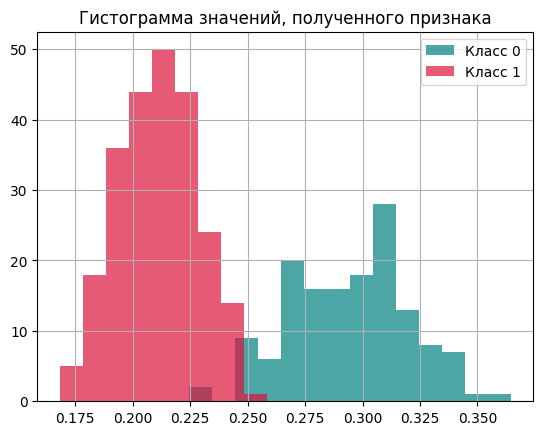

In [11]:
binwidth = 0.01
plt.hist(y0, bins=np.arange(min(y0), max(y0) + binwidth, binwidth), label='Класс 0', alpha=0.7, color = 'teal')
plt.hist(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth), label='Класс 1', alpha=0.7, color = 'crimson')
plt.title("Гистограмма значений, полученного признака")
plt.legend()
plt.grid()
plt.show()

### 6. Найти порог класификации

In [12]:
# Calculate histograms
y0_hist = np.histogram(y0, bins=np.arange(min(y0), max(y0) + binwidth, binwidth))
y1_hist = np.histogram(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth))

# Find peaks of histograms
y0_max = max(y0_hist[0])
y1_max = max(y1_hist[0])

# Find location of peaks
y0_max_coord = y0_hist[1][np.argwhere(y0_hist[0]==y0_max)[0][0]]
y1_max_coord = y1_hist[1][np.argwhere(y1_hist[0]==y1_max)[0][0]]

In [13]:
y0_max_coord, y1_max_coord

(0.30451511318583435, 0.20831684418289179)

In [14]:
threshold_range = np.arange(y1_max_coord, y0_max_coord, 0.0001)

In [15]:
def count_rel_error(hist_1, hist_2, thr):
    err_1 = np.sum(hist_1[0][np.nonzero(hist_1[1] < thr)[0]]) / hist_1[0].sum()
    err_2 = np.sum(hist_2[0][np.nonzero(hist_2[1] > thr)[0]-1]) / hist_2[0].sum()
    return (err_1+err_2)/2

In [16]:
error_range = np.array([count_rel_error(y0_hist, y1_hist, thr_x) for thr_x in threshold_range])
thr_new = threshold_range[np.argmin(error_range)]
thr_new

0.23841684418288847

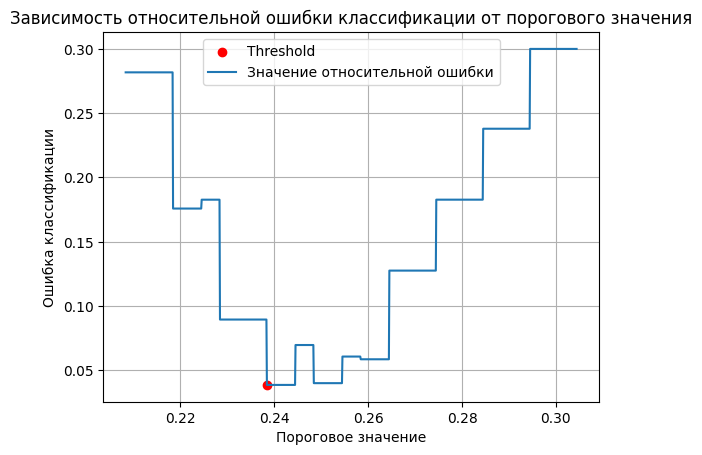

In [17]:
plt.scatter(thr_new, np.min(error_range), c="r", label='Threshold')
plt.plot(threshold_range, error_range, label='Значение относительной ошибки')
plt.title("Зависимость относительной ошибки классификации от порогового значения")
plt.xlabel("Пороговое значение")
plt.ylabel("Ошибка классификации")
plt.legend()
plt.grid()
plt.show()

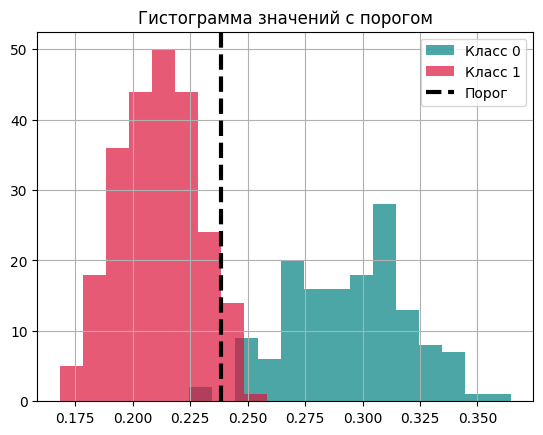

In [18]:
binwidth = 0.01
plt.hist(y0, bins=np.arange(min(y0), max(y0) + binwidth, binwidth), label='Класс 0', alpha=0.7, color = 'teal')
plt.hist(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth), label='Класс 1', alpha=0.7, color = 'crimson')
plt.axvline(thr_new, color='black', linestyle='dashed', linewidth=3, label='Порог')
plt.title("Гистограмма значений с порогом")
plt.legend()
plt.grid()
plt.show()

### 7. Оценить точность классификации на test наборе: построить матрицу неточности.

In [19]:
print("Ошибка на тренировочной выборке составила: %.4f" % np.min(error_range))

Ошибка на тренировочной выборке составила: 0.0387


In [22]:
y0_test = W.dot(X_test_0.T)
y1_test = W.dot(X_test_1.T)
y1_hist_test = np.histogram(y1_test, bins=np.arange(min(y1_test), max(y1_test) + binwidth, binwidth))
y0_hist_test = np.histogram(y0_test, bins=np.arange(min(y0_test), max(y0_test) + binwidth, binwidth))
error_test = count_rel_error(y0_hist_test, y1_hist_test, thr_new)
error_test

0.1215616134205008

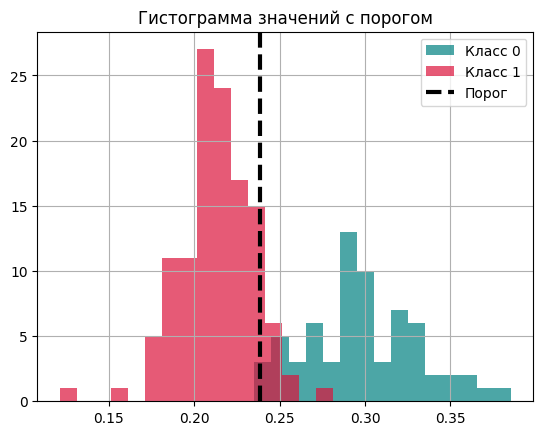

In [23]:
binwidth = 0.01
plt.hist(y0_test, bins=np.arange(min(y0_test), max(y0_test) + binwidth, binwidth), label='Класс 0', alpha=0.7, color = 'teal')
plt.hist(y1_test, bins=np.arange(min(y1_test), max(y1_test) + binwidth, binwidth), label='Класс 1', alpha=0.7, color = 'crimson')
plt.axvline(thr_new, color='black', linestyle='dashed', linewidth=3, label='Порог')
plt.title("Гистограмма значений с порогом")
plt.legend()
plt.grid()
plt.show()

In [24]:
def plot_confusion_matrix(y_true, y_pred, ax, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

In [25]:
y_pred = W.dot(X_test.T) < thr_new

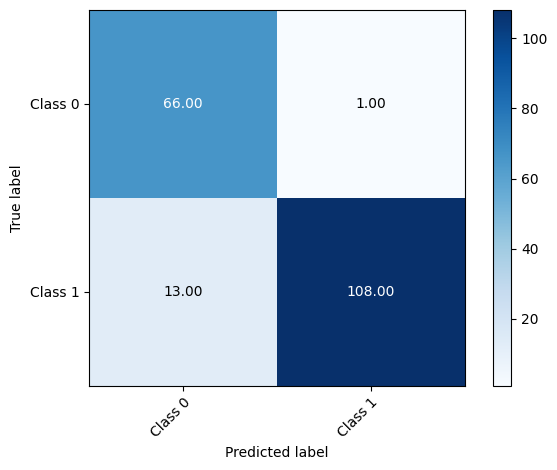

In [26]:
fig, ax = plt.subplots()
plot_confusion_matrix(y_test, y_pred, ax, classes=np.array(["Class 0", "Class 1"]))
fig.tight_layout()

## "Из коробки":

### 1. Применить LinearDiscriminantAnalysis() с разными solver (solver{‘svd’, ‘lsqr’, ‘eigen’}) к train набору

In [29]:
lda1 = LinearDiscriminantAnalysis('svd')
lda2 = LinearDiscriminantAnalysis('eigen')
lda3 = LinearDiscriminantAnalysis('lsqr')
lda1.fit(X_train,y_train)
lda2.fit(X_train,y_train)
lda3.fit(X_train,y_train)

LinearDiscriminantAnalysis(solver='lsqr')

### 2. Сравнить средние значения классов с значеними из предыдущего метода

In [30]:
lda1.means_ - np.array([mean_0,mean_1])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [31]:
lda2.means_ - np.array([mean_0,mean_1])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [33]:
lda3.means_ - np.array([mean_0,mean_1])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### 3. Сравнить вектор W проекции с вектором из предыдущего метода

In [34]:
lda1.coef_[0] - W

array([ 2.69977057e+00,  2.15685542e-01, -4.10624216e-01,  1.52980125e-03,
       -3.41140761e+01,  1.13597720e+02, -6.80495676e+00, -1.47236421e+02,
        6.38794672e+00, -7.81975270e+01, -7.56570421e+00,  1.87586694e+00,
       -2.95688026e-01,  3.18810158e-02, -4.67025802e+02,  3.85799559e+01,
        9.07974766e+01, -3.86325799e+02,  2.59537193e+01, -1.17706182e+02,
       -3.30572200e+00, -4.55369706e-01,  1.43149305e-01,  1.48567661e-02,
        2.18673294e+01, -1.85044944e+01, -1.87609575e+01,  4.55945879e+01,
       -2.04781391e+01, -2.26290265e+00])

In [35]:
lda2.coef_[0] - W

array([ 2.71394316e+00,  2.16817776e-01, -4.12779786e-01,  1.53783082e-03,
       -3.42931592e+01,  1.14194053e+02, -6.84068233e+00, -1.48009338e+02,
        6.42148059e+00, -7.86080278e+01, -7.60542037e+00,  1.88571431e+00,
       -2.97240255e-01,  3.20483774e-02, -4.69477458e+02,  3.87824822e+01,
        9.12741184e+01, -3.88353817e+02,  2.60899606e+01, -1.18324068e+02,
       -3.32307548e+00, -4.57760161e-01,  1.43900771e-01,  1.49347568e-02,
        2.19821228e+01, -1.86016343e+01, -1.88594425e+01,  4.58339381e+01,
       -2.05856391e+01, -2.27478292e+00])

In [36]:
lda3.coef_[0] - W

array([ 2.71394316e+00,  2.16817776e-01, -4.12779785e-01,  1.53783083e-03,
       -3.42931591e+01,  1.14194053e+02, -6.84068235e+00, -1.48009338e+02,
        6.42148059e+00, -7.86080278e+01, -7.60542036e+00,  1.88571431e+00,
       -2.97240256e-01,  3.20483774e-02, -4.69477458e+02,  3.87824822e+01,
        9.12741185e+01, -3.88353817e+02,  2.60899606e+01, -1.18324068e+02,
       -3.32307548e+00, -4.57760161e-01,  1.43900771e-01,  1.49347568e-02,
        2.19821228e+01, -1.86016343e+01, -1.88594425e+01,  4.58339381e+01,
       -2.05856391e+01, -2.27478292e+00])

### 4. Выполнить transform и получить проекцию данных

In [39]:
y_1 = lda1.transform(X_train).reshape(-1)
y_2 = lda2.transform(X_train).reshape(-1)
y_3 = (lda3.coef_.dot(X_train.T) + lda3.intercept_).reshape(-1)
y0_1 = lda1.transform(X_train_0).reshape(-1)
y1_1 = lda1.transform(X_train_1).reshape(-1)
y0_2 = lda2.transform(X_train_0).reshape(-1)
y1_2 = lda2.transform(X_train_1).reshape(-1)
y0_3 = (lda3.coef_.dot(X_train_0.T) + lda3.intercept_).reshape(-1)
y1_3 = (lda3.coef_.dot(X_train_1.T) + lda3.intercept_).reshape(-1)

### 5. Сравнить полученные распределения проекций данных классов с распредлением из предыдущего метода, сравнить реузльтат для разных solver

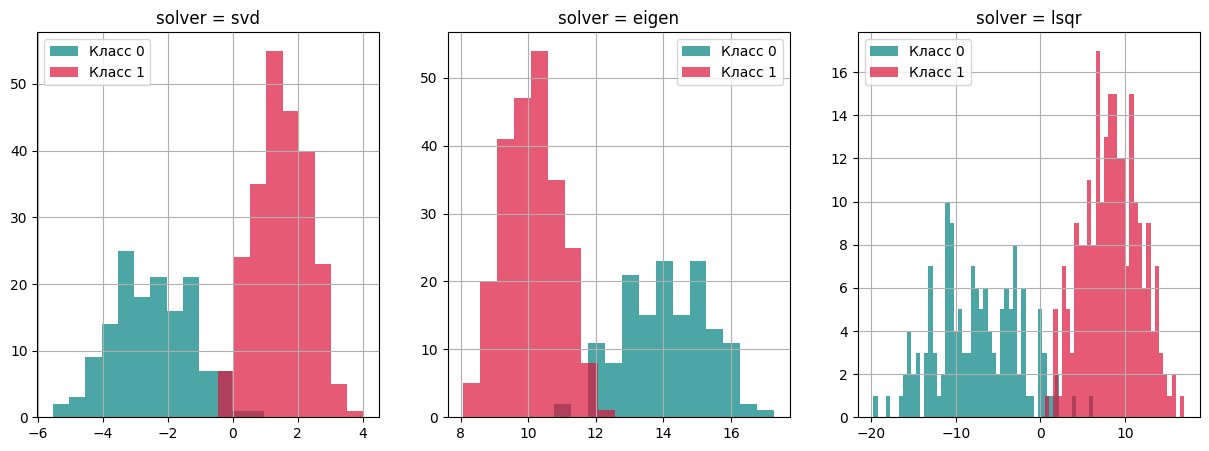

In [40]:
binwidth = 0.5
fig, axs = plt.subplots(1,3,figsize=(15,5))
for ax, y0, y1, solver in zip(axs,[y0_1,y0_2,y0_3],[y1_1,y1_2,y1_3],['svd', 'eigen','lsqr']):
    ax.hist(y0, bins=np.arange(min(y0), max(y0) + binwidth, binwidth), label='Класс 0', alpha=0.7, color = 'teal')
    ax.hist(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth), label='Класс 1', alpha=0.7, color = 'crimson')
    ax.set_title('solver = '+solver)
    ax.legend()
    ax.grid()
plt.show()

### 6. Оценить точность классификации на test наборе: построить матрицу неточности.

In [41]:
y_pred1 = lda1.predict(X_test)
y_pred2 = lda2.predict(X_test)
y_pred3 = lda3.predict(X_test)
print(np.prod(y_pred1 == y_pred2))

1


In [243]:
print(np.prod(y_pred1 == y_pred3))

1


In [244]:
print(np.prod(y_pred1 == y_pred))

1


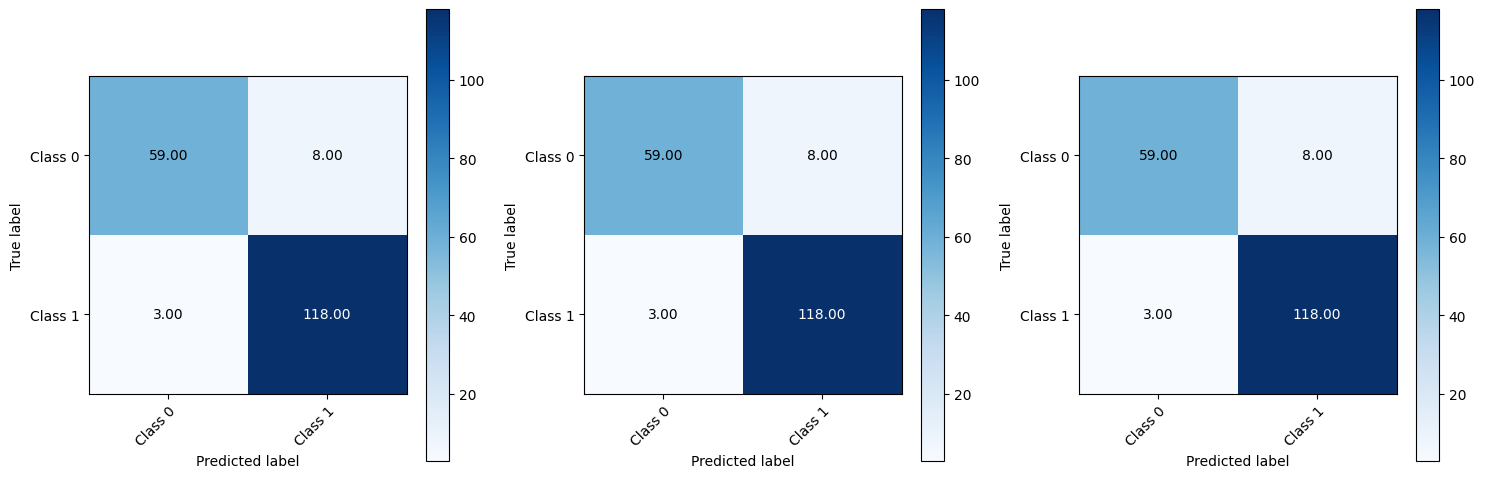

In [42]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
for y_pred, ax in zip([y_pred1,y_pred2,y_pred3],axs):
    plot_confusion_matrix(y_test, y_pred, ax, classes=np.array(["Class 0", "Class 1"]))
fig.tight_layout()